[View in Colaboratory](https://colab.research.google.com/github/silentvoice/dl-with-keras/blob/master/classification-cats-vs-dogs-from-scratch.ipynb)

# Classification Kaggle Cats Vs Dogs

In [0]:
# this resets the state of the machine (e.g. if you want to re-install from scratch  # this  
# or reset memory usage in this instance)
# wait a minute after running it and then reload the page
#!kill -9 -1

## Check Tensorflow Version

In [1]:
import tensorflow as tf

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
tf.__version__

'1.9.0-rc2'

## Imports

In [4]:
from tensorflow import keras
from tensorflow.python.keras import layers, models, optimizers
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os, shutil

## Load Kaggle Dogs Dataset

In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

In [6]:
# Check if the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 66 Jul  7 18:03 kaggle.json


In [7]:
# Install the Kaggle API client.
!pip install -q kaggle

In [8]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 /content/.kaggle/kaggle.json

In [9]:
# Download dataset from kaggle
!mkdir -p data/cats-vs-dogs && kaggle competitions download -c dogs-vs-cats -p data/cats-vs-dogs/

  0%|                                               | 0.00/86.8k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 86.8k/86.8k [00:00<00:00, 32.1MB/s]
 93%|█████████████████████████████████████▉   | 251M/271M [00:01<00:00, 179MB/s]
100%|█████████████████████████████████████████| 271M/271M [00:01<00:00, 190MB/s]
100%|████████████████████████████████████████▉| 543M/543M [00:03<00:00, 144MB/s]
100%|█████████████████████████████████████████| 543M/543M [00:03<00:00, 168MB/s]


In [0]:
!mkdir data/cats-vs-dogs/orig_data && unzip data/cats-vs-dogs/train.zip -d data/cats-vs-dogs/orig_data/

In [11]:
orig_data_dir = '/content/data/cats-vs-dogs/orig_data/train'

In [12]:
base_dir = '/content/data/small-cats-vs-dogs'
os.mkdir(base_dir)

In [13]:
# Create Train, Validation and Test folders
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [14]:
# Prepare folders for cats and dogs  
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

In [15]:
!ls data/cats-vs-dogs/orig_data/train | head


cat.0.jpg
cat.10000.jpg
cat.10001.jpg
cat.10002.jpg
cat.10003.jpg
cat.10004.jpg
cat.10005.jpg
cat.10006.jpg
cat.10007.jpg
cat.10008.jpg
ls: write error: Broken pipe


In [16]:
# create a smaller train, validation and test dataset from orig_data
train_cat_f_names = ['cat.{}.jpg'.format(i) for i in range(1000)]
train_dog_f_names = ['dog.{}.jpg'.format(i) for i in range(1000)]

val_cat_f_names = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
val_dog_f_names = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]

test_cat_f_names = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
test_dog_f_names = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]

In [17]:
for f_name in train_cat_f_names:
  src = os.path.join(orig_data_dir, f_name)
  dst = os.path.join(train_cats_dir, f_name)
  shutil.copyfile(src, dst)
  
for f_name in val_cat_f_names:
  src = os.path.join(orig_data_dir, f_name)
  dst = os.path.join(validation_cats_dir, f_name)
  shutil.copyfile(src, dst)
  
for f_name in test_cat_f_names:
  src = os.path.join(orig_data_dir, f_name)
  dst = os.path.join(test_cats_dir, f_name)
  shutil.copyfile(src, dst)

for f_name in train_dog_f_names:
  src = os.path.join(orig_data_dir, f_name)
  dst = os.path.join(train_dogs_dir, f_name)
  shutil.copyfile(src, dst)
  
for f_name in val_dog_f_names:
  src = os.path.join(orig_data_dir, f_name)
  dst = os.path.join(validation_dogs_dir, f_name)
  shutil.copyfile(src, dst)
  
for f_name in test_dog_f_names:
  src = os.path.join(orig_data_dir, f_name)
  dst = os.path.join(test_dogs_dir, f_name)
  shutil.copyfile(src, dst) 

In [18]:
len(os.listdir(train_cats_dir))

1000

In [19]:
len(os.listdir(train_dogs_dir))

1000

## Data Preparation 


In [20]:
train_data_gen = ImageDataGenerator(rescale=1.0/255)
val_data_gen = ImageDataGenerator(rescale=1.0/255)

In [21]:
train_data_generator = train_data_gen.flow_from_directory(train_dir,
                                                          target_size=(150, 150),
                                                          batch_size=20,
                                                          class_mode='binary')
val_data_generator = val_data_gen.flow_from_directory(validation_dir,
                                                      target_size=(150, 150),
                                                      batch_size=20,
                                                      class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [22]:
for train_batch_data, train_batch_labels in train_data_generator:
  print(train_batch_data.shape, train_batch_labels.shape)
  break

(20, 150, 150, 3) (20,)


## Model

In [0]:
def create_model():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Conv2D(128, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Conv2D(128, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizers.RMSprop(lr=1e-3),
                loss='binary_crossentropy',
                metrics=['acc'])
  return model

In [0]:
model = create_model()

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)       147584    
__________

## Train the Model

In [0]:
model_history = model.fit_generator(train_data_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=val_data_generator,
                    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 13s 131ms/step - loss: 0.7749 - acc: 0.5235 - val_loss: 0.6856 - val_acc: 0.5530
Epoch 2/30
100/100 [==============================] - 12s 116ms/step - loss: 0.6849 - acc: 0.5845 - val_loss: 0.6625 - val_acc: 0.5390
Epoch 3/30
100/100 [==============================] - 11s 114ms/step - loss: 0.6353 - acc: 0.6435 - val_loss: 0.6103 - val_acc: 0.6550
Epoch 4/30
 79/100 [======================>.......] - ETA: 1s - loss: 0.6067 - acc: 0.6943100/100 [==============================] - 11s 113ms/step - loss: 0.5976 - acc: 0.7040 - val_loss: 0.5575 - val_acc: 0.7140
Epoch 5/30
100/100 [==============================] - 11s 114ms/step - loss: 0.5474 - acc: 0.7325 - val_loss: 0.5725 - val_acc: 0.6860
Epoch 6/30
100/100 [==============================] - 12s 115ms/step - loss: 0.4794 - acc: 0.7665 - val_loss: 0.6714 - val_acc: 0.6710
Epoch 7/30
 98/100 [============================>.] - ETA: 0s - loss: 0.4483 - acc: 0.7934100/100 [============

In [0]:
model.save('small-cats-vs-dogs-1.h5')

## Plot Train and Validation loss and accuracy

In [0]:
train_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

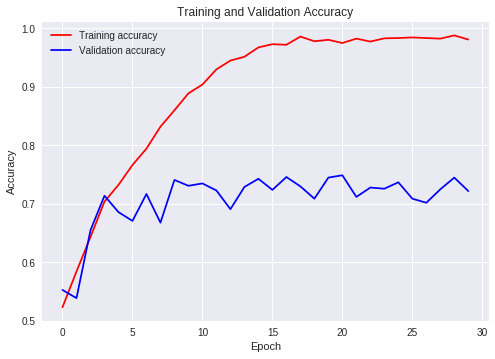

In [0]:
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

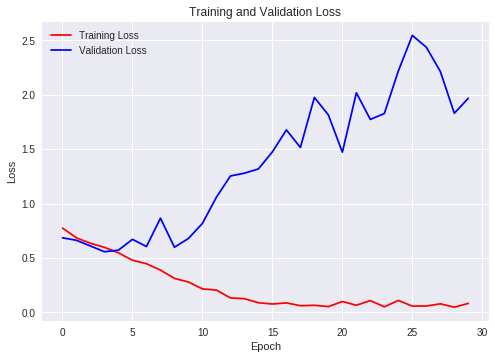

In [0]:
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Data augmentation to improve the model as we are using a small dataset



In [0]:
data_generator = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

### Check the augmentation of the images

In [0]:
f_names = [os.path.join(train_dogs_dir, f_name) for f_name in os.listdir(train_dogs_dir)]

In [0]:
img_pth = f_names[1]
img = image.load_img(img_pth, target_size=(150, 150))
img_arr = image.img_to_array(img)
img_arr = img_arr.reshape((1,) + img_arr.shape)

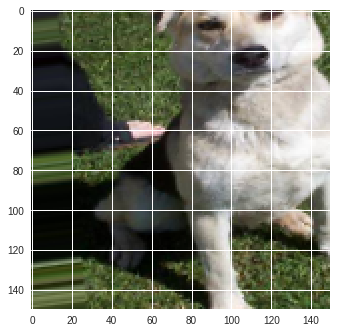

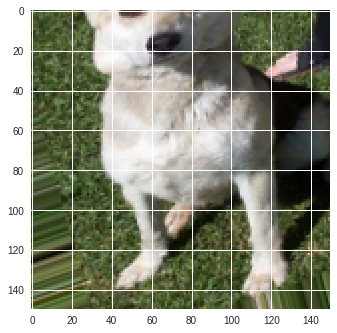

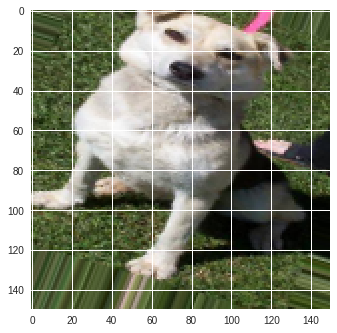

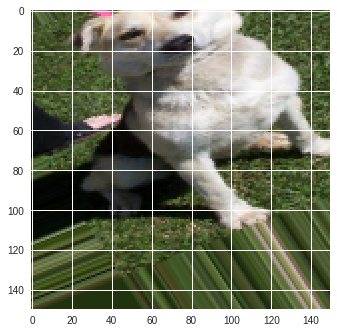

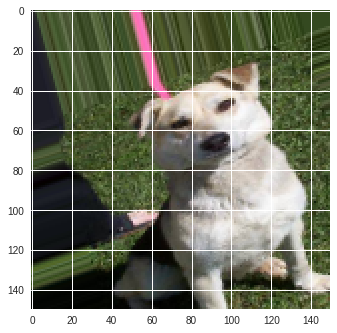

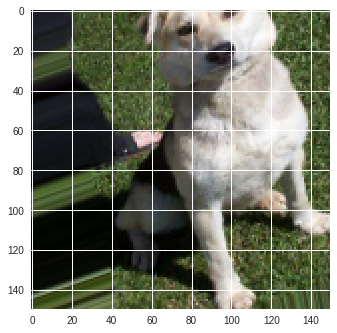

In [0]:
for idx, batch in enumerate(data_generator.flow(img_arr, batch_size=1)):
  plt.figure(idx)
  img_plot = plt.imshow(image.array_to_img(batch[0]))
  if idx > 4:
    break

In [23]:
# add regurization in the previous model using dropout
def create_model():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Conv2D(128, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Conv2D(128, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer=optimizers.RMSprop(lr=1e-3),
                loss='binary_crossentropy',
                metrics=['acc'])
  return model

In [24]:
model = create_model()

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [26]:
train_data_gen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
val_data_gen = ImageDataGenerator(rescale=1.0/255)

In [27]:
train_data_generator = train_data_gen.flow_from_directory(train_dir,
                                                          target_size=(150, 150),
                                                          batch_size=32,
                                                          class_mode='binary')
val_data_generator = val_data_gen.flow_from_directory(validation_dir,
                                                      target_size=(150, 150),
                                                      batch_size=32,
                                                      class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [28]:
model_history = model.fit_generator(train_data_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=val_data_generator,
                    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 37s 373ms/step - loss: 0.7382 - acc: 0.5344 - val_loss: 0.6852 - val_acc: 0.5673
Epoch 2/30
100/100 [==============================] - 34s 336ms/step - loss: 0.6924 - acc: 0.5563 - val_loss: 0.6745 - val_acc: 0.6003
Epoch 3/30
100/100 [==============================] - 33s 332ms/step - loss: 0.6690 - acc: 0.5737 - val_loss: 0.7448 - val_acc: 0.5939
Epoch 4/30
 65/100 [==================>...........] - ETA: 8s - loss: 0.6743 - acc: 0.5966100/100 [==============================] - 33s 330ms/step - loss: 0.6663 - acc: 0.6084 - val_loss: 0.7077 - val_acc: 0.5190
Epoch 5/30
100/100 [==============================] - 32s 325ms/step - loss: 0.6432 - acc: 0.6534 - val_loss: 0.6586 - val_acc: 0.6390
Epoch 6/30
100/100 [==============================] - 35s 354ms/step - loss: 0.6188 - acc: 0.6594 - val_loss: 0.7178 - val_acc: 0.5869
Epoch 7/30
 83/100 [=======================>......] - ETA: 4s - loss: 0.6100 - acc: 0.6739100/100 [============

### Plot results after augmentation and regularization

In [29]:
model.save('small-cats-vs-dogs-2.h5')

In [30]:
train_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

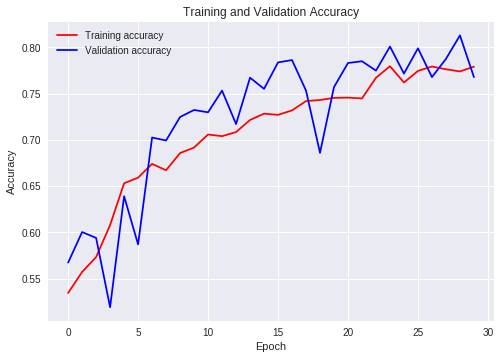

In [31]:
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

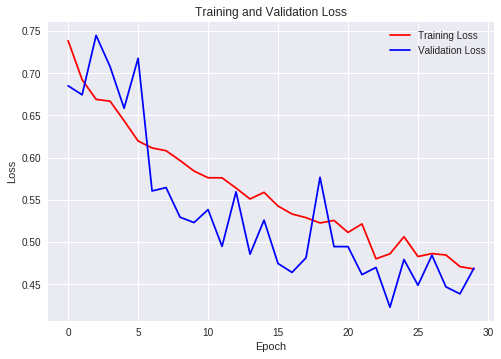

In [32]:
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Visualize Activations

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [41]:
## Load a Test Image
img = image.load_img('/content/data/small-cats-vs-dogs/test/dogs/dog.1501.jpg', target_size=(150, 150))

In [42]:
img_tensor = image.img_to_array(img)

In [43]:
img_tensor = np.expand_dims(img_tensor, axis=0)

In [44]:
img_tensor /= 255.

In [45]:
img_tensor.shape

(1, 150, 150, 3)

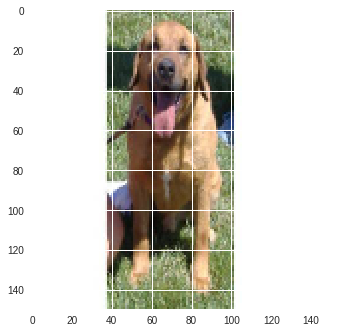

In [46]:
plt.imshow(img_tensor[0])

In [47]:
layer_outputs = [layer.output for layer in model.layers[:8]]

In [49]:
activation_model = models.Model(model.input, layer_outputs)

In [50]:
activations = activation_model.predict(img_tensor)

In [53]:
fst_lyr_actns = activations[0]
fst_lyr_actns.shape

(1, 148, 148, 32)

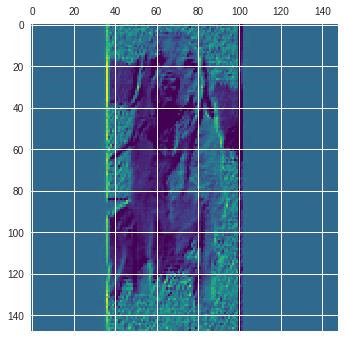

In [59]:
plt.matshow(fst_lyr_actns[0, :, :, 1], cmap='viridis')

In [60]:
l_names = []
for l in model.layers[:8]:
  l_names.append(l.name)

In [61]:
img_per_row = 16

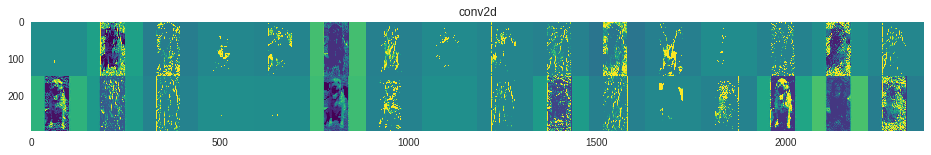

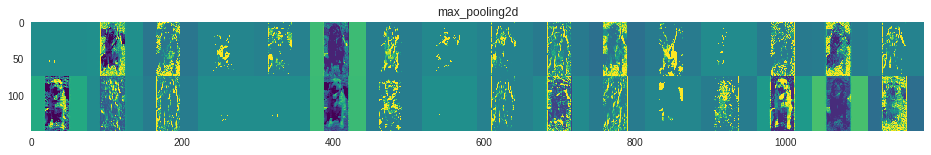

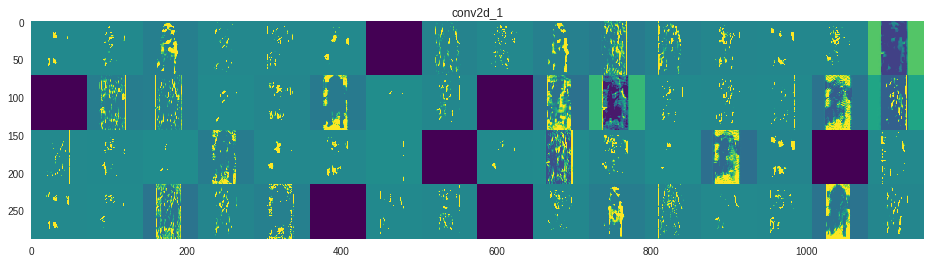

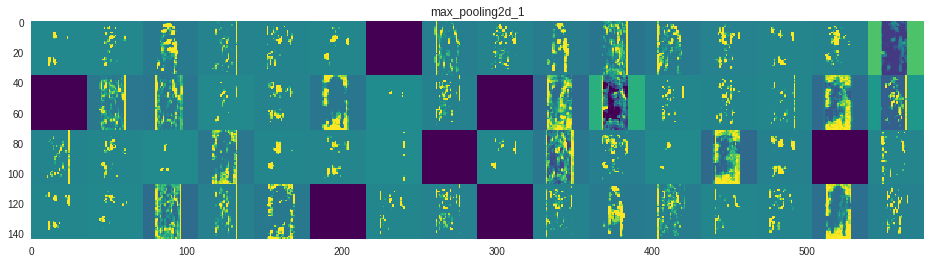

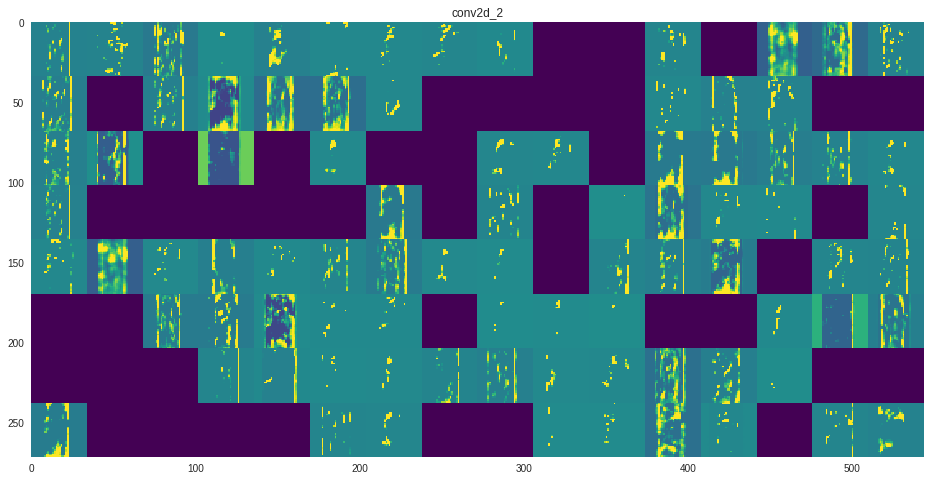

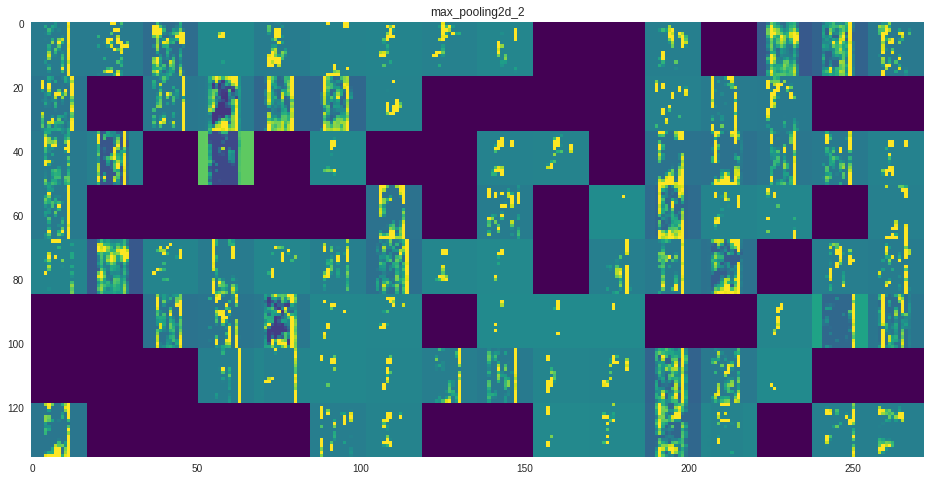

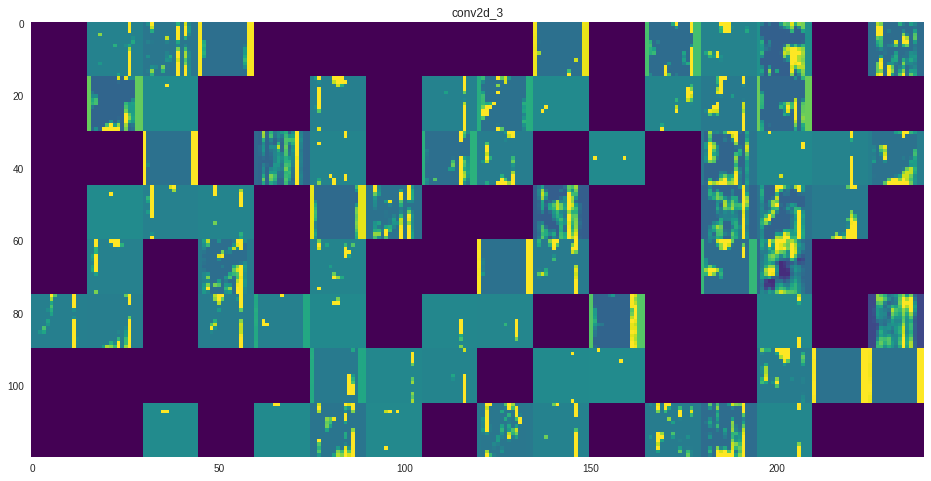

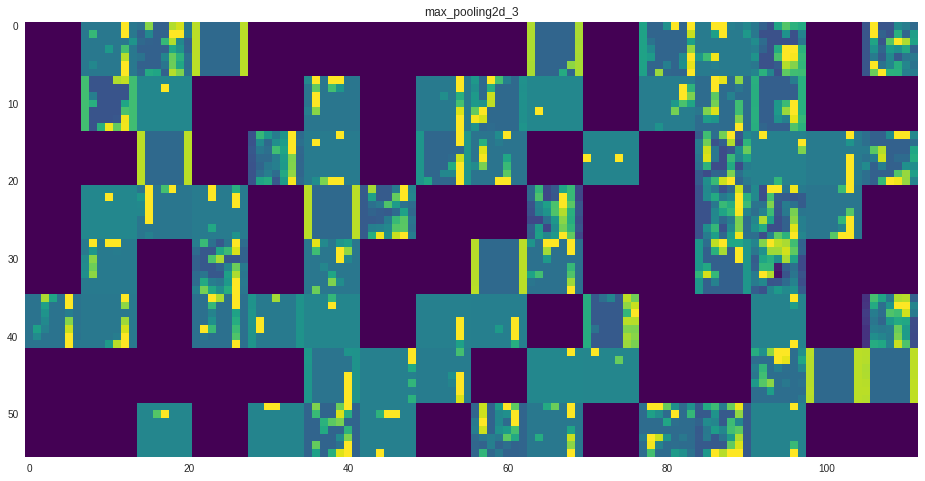

In [67]:
for l_n, l_a in zip(l_names, activations):
  n_features = l_a.shape[-1]
  size = l_a.shape[1]
  n_cols = n_features // img_per_row
  grid_sz = np.zeros((size*n_cols, img_per_row*size))
  for c in range(n_cols):
    for r in range(img_per_row):
      chnl_img = l_a[0,:,:, c*img_per_row + r]
      chnl_img -= chnl_img.mean()
      chnl_img /= chnl_img.std()
      chnl_img *= 64
      chnl_img += 128
      chnl_img = np.clip(chnl_img, 0, 255).astype('uint8')
      grid_sz[c * size: (c + 1) * size, r * size: (r + 1) * size] = chnl_img
  scale = 1./size
  plt.figure(figsize=(scale * grid_sz.shape[1], scale * grid_sz.shape[0]))
  plt.title(l_n)
  plt.grid(False)
  plt.imshow(grid_sz, aspect='auto', cmap='viridis')                                                                    